In [1]:
import pandas as pd
import censusdata
import os
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import h5py
import numpy as np
from pygris import block_groups
import contextily as cx
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import numpy as np

warnings.filterwarnings("ignore")

data_path = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/BEAM-CORE/Lab call/PSRC'
os.chdir(data_path)

plt.style.use('ggplot')
sns.set_theme(style="whitegrid", font_scale=1.4)  # larger font

In [2]:
# load PSRC parcel geography
parcel_geography = pd.read_csv('SoundCast_processed/parcel_2018_geography.csv')
print(len(parcel_geography))
parcel_geography_short = \
parcel_geography[['ParcelID','CityName', 'Census2010Block',
       'Census2010BlockGroup', 'Census2010Tract', 'FAZID', 'taz_p', 
                  'District', 'district_name', 'CountyName', 'TAZ', 
                  'BaseYear', 'GEOID10', 'place_name']]
parcel_geography_short.head(5)
parcel_geography_short.loc[:, 'Census2010BlockGroup'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].astype(str).str.zfill(0)
parcel_geography_short.loc[:, 'State'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].str[0:2] 
parcel_geography_short.loc[:, 'County'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].str[2:5]
parcel_geography_short.loc[:, 'FIPS'] = \
parcel_geography_short.loc[:, 'Census2010BlockGroup'].str[0:5] 

state = parcel_geography_short['State'].unique()[0]
list_of_fips = parcel_geography_short.County.unique()
print(state, list_of_fips)

1302434
53 ['033' '061' '053' '035']


In [3]:
# load UrbanSim population
urbansim_file_path = 'UrbanSim/model_data_2018.h5'
store = pd.HDFStore(urbansim_file_path,"r")
urbansim_household = store['/2018/households']
urbansim_household = urbansim_household.loc[urbansim_household['lcm_county_id'] != '-1']
urbansim_persons = store['/2018/persons']

urbansim_household.loc[:, 'state'] = urbansim_household.loc[:, 'lcm_county_id'].str[0:2]
urbansim_household.loc[:, 'County'] = urbansim_household.loc[:, 'lcm_county_id'].str[2:5]
urbansim_household = urbansim_household.reset_index()
urbansim_persons = urbansim_persons.reset_index()
# print(store.keys())  
urbansim_household.head(5)

,household_id,seniors,hispanic_status_of_head,gt2,hh_income,hh_race_of_head,workers,hh_cars,cars,age_of_head,...,sf_detached,recent_mover,tenure_mover,hh_size,block_id,serialno,hh_type,persons,state,County
0,0,0.0,0,0,lt30,other,0.0,none,0.0,64,...,no,0,rent not recent,one,530330052001000,2011001205616,6,1,53,033
1,1,0.0,0,0,lt30,other,0.0,none,0.0,64,...,no,0,rent not recent,one,530330052001000,2011001205616,6,1,53,033
2,2,0.0,0,0,lt30,white,0.0,none,0.0,61,...,no,0,rent not recent,one,530330052001000,2011000244283,6,1,53,033
3,3,0.0,0,0,lt30,white,0.0,none,0.0,61,...,no,0,rent not recent,one,530330052001000,2011000244283,6,1,53,033
4,4,0.0,0,0,lt30,white,1.0,none,0.0,47,...,no,0,rent not recent,one,530330052001004,2009001123248,5,1,53,033


In [4]:
print(urbansim_household.columns)
print(urbansim_persons.columns)
print(urbansim_household.groupby('lcm_county_id').size())
urbansim_household[['hh_income', 'income']].head(5)

Index(['household_id', 'seniors', 'hispanic_status_of_head', 'gt2',
       'hh_income', 'hh_race_of_head', 'workers', 'hh_cars', 'cars',
       'age_of_head', 'hh_seniors', 'hh_workers', 'income', 'hispanic_head',
       'tenure', 'hh_age_of_head', 'lcm_county_id', 'gt55', 'hh_children',
       'race_of_head', 'sf_detached', 'recent_mover', 'tenure_mover',
       'hh_size', 'block_id', 'serialno', 'hh_type', 'persons', 'state',
       'County'],
      dtype='object')
Index(['person_id', 'race_id', 'race', 'p_hispanic', 'earning', 'work_at_home',
       'age', 'sex', 'household_id', 'hours', 'hispanic.1', 'member_id',
       'student', 'person_age', 'hispanic', 'relate', 'worker', 'person_sex',
       'edu'],
      dtype='object')
lcm_county_id
53033    851261
53035    107367
53053    325375
53061    286659
dtype: int64


,hh_income,income
0,lt30,8100.0
1,lt30,8100.0
2,lt30,8400.0
3,lt30,8400.0
4,lt30,15300.0


In [4]:
# load PSRC population
analysis_year = 2018
psrc_households = read_csv('SoundCast_processed/households_PSRC_' + \
                       str(analysis_year) + '.csv')

psrc_persons = read_csv('SoundCast_processed/persons_PSRC_' + \
                       str(analysis_year) + '.csv')

In [10]:
psrc_households.hhexpfac.unique()

array([1])

In [5]:
# assign geography to PSRC population
psrc_households_by_loc = pd.merge(psrc_households,
                           parcel_geography_short,
                           left_on = 'hhparcel',
                           right_on = 'ParcelID',
                           how = 'left')
# psrc_households_by_loc.head(5)
pop_by_cbg = psrc_households_by_loc.groupby(['Census2010BlockGroup'])[['hhexpfac', 'hhsize']].sum()
pop_by_cbg = pop_by_cbg.reset_index()
pop_by_cbg.columns = ['GEOID', 'HOUSEHOLDS', 'POPULATION']
pop_by_cbg.loc[:, 'GEOID'] = \
pop_by_cbg.loc[:, 'GEOID'].astype(float).astype(int).astype(str)
print(len(pop_by_cbg))
pop_by_cbg.head(5)

2639


,GEOID,HOUSEHOLDS,POPULATION
0,530330001001,541,1328
1,530330001002,858,1748
2,530330001003,809,1611
3,530330001004,1115,2173
4,530330001005,619,1047


In [7]:
psrc_households_by_loc.to_csv('SoundCast_processed/households_PSRC_' + \
                       str(analysis_year) + '_withGEOID.csv')

In [6]:
region_cbg_map = block_groups(state = state, year = analysis_year)
# region_cbg_map.head(5)
region_cbg_map = region_cbg_map[['GEOID', 'ALAND', 'geometry']]
region_cbg_map.loc[:, 'GEOID'] = \
region_cbg_map.loc[:, 'GEOID'].astype(str).str.zfill(12)

region_cbg_map = region_cbg_map.merge(pop_by_cbg,
                                      on = 'GEOID',
                                      how = 'inner')
print(len(region_cbg_map))
region_cbg_map.head(5)

2639


,GEOID,ALAND,geometry,HOUSEHOLDS,POPULATION
0,530610518023,1847888,"POLYGON ((-122.28188 47.84291, -122.28146 47.8...",547,1489
1,530530634006,319199,"POLYGON ((-122.44199 47.17191, -122.44197 47.1...",273,767
2,530330219042,367206,"POLYGON ((-122.17557 47.72344, -122.17328 47.7...",321,972
3,530330219044,318915,"POLYGON ((-122.17558 47.72581, -122.17323 47.7...",330,977
4,530330219051,759979,"POLYGON ((-122.18723 47.74653, -122.18719 47.7...",758,1605


In [7]:
region_cbg_map.to_file('SoundCast_processed/pop_by_cbg.geojson', 
                       driver = 'GeoJSON')

EPSG:4269


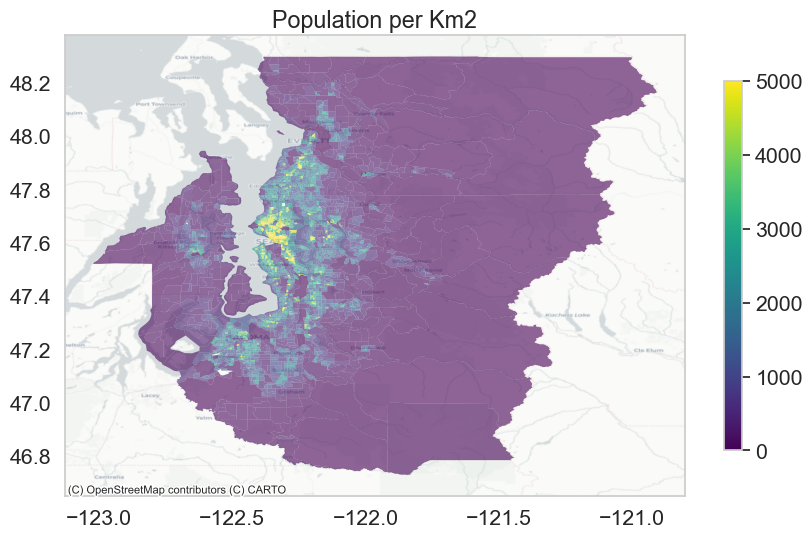

In [8]:
print(region_cbg_map.crs)
region_cbg_map.loc[:, 'pop_per_km2'] = \
region_cbg_map.loc[:, 'POPULATION'] / region_cbg_map.loc[:, 'ALAND'] * 10**6
ax = region_cbg_map.plot(figsize = (10,12), 
                         column = 'pop_per_km2', 
                         cmap='viridis',
                         alpha = 0.6, 
                        vmin = 0, vmax =5000, 
                         linewidth=0.01, legend=True,
                          legend_kwds = {'shrink': 0.4})
plt.title('Population per Km2')
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs = 'EPSG:4269')
ax.grid(False)
plt.savefig('plot/PSRC_pop_density_2018.png', dpi = 300, bbox_inches = 'tight')

In [7]:
# compare UrbanSim and PSRC data at CBG level
urbansim_household.loc[:, 'GEOID'] = \
urbansim_household.loc[:, 'block_id'].astype(str).str.zfill(15).str[0:12]
urbansim_household[['block_id', 'GEOID']].head(5)
usim_hh_by_cbg = urbansim_household.groupby(['GEOID'])[['household_id']].count()
usim_hh_by_cbg = usim_hh_by_cbg.reset_index()
usim_hh_by_cbg.columns = ['GEOID', 'USim_HOUSEHOLDS']
usim_pop_by_cbg = urbansim_household.groupby(['GEOID'])[['persons']].sum()
usim_pop_by_cbg = usim_pop_by_cbg.reset_index()
usim_pop_by_cbg.columns = ['GEOID', 'USim_POPULATION']
usim_pop_by_cbg = pd.merge(usim_pop_by_cbg, usim_hh_by_cbg, on = 'GEOID', how = 'left')
usim_pop_by_cbg.head(5)

,GEOID,USim_POPULATION,USim_HOUSEHOLDS
0,530330001001,1221,565
1,530330001002,1317,658
2,530330001003,1429,744
3,530330001004,1555,838
4,530330001005,1015,638


2641
POPULATION
303.8 0.67
HOUSEHOLDS
134.3 0.66
GEOID              5303300010015303300010025303300010035303300010...
PSRC_HOUSEHOLDS                                            1605263.0
PSRC_POPULATION                                            4053154.0
USim_POPULATION                                              3829882
USim_HOUSEHOLDS                                              1570662
dtype: object


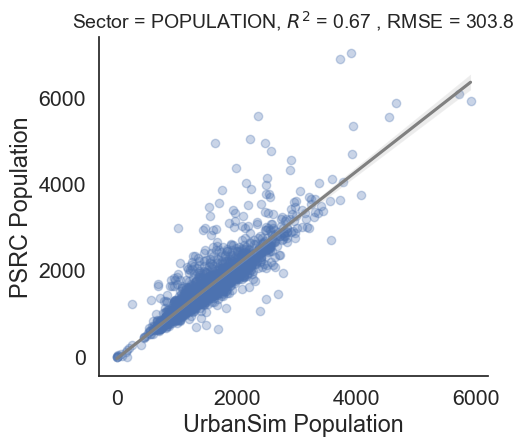

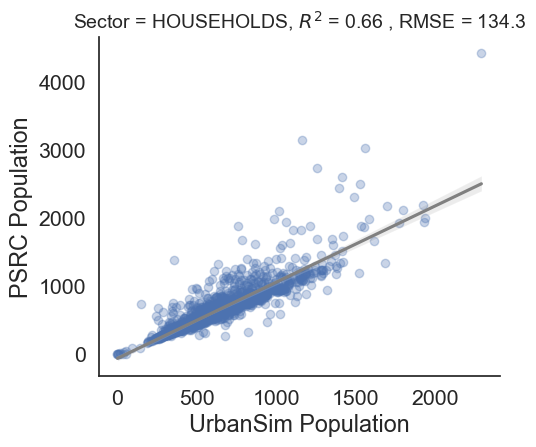

In [8]:


psrc_pop_by_cbg = pop_by_cbg.copy()
psrc_pop_by_cbg.columns = ['GEOID', 'PSRC_HOUSEHOLDS', 'PSRC_POPULATION']
psrc_pop_by_cbg.head(5)
pop_comparison = pd.merge(psrc_pop_by_cbg, usim_pop_by_cbg, on = 'GEOID', how = 'outer')
print(len(pop_comparison))

pop_comparison.fillna(0, inplace = True)
joint_sector = ['POPULATION', 'HOUSEHOLDS']


for sec in joint_sector:
    print(sec)
    usim_attr = 'USim_' + sec
    psrc_attr = 'PSRC_' + sec

    rmse_emp = mean_squared_error(pop_comparison[usim_attr], 
                                  pop_comparison[psrc_attr], squared = False)
    r2_emp = r2_score(pop_comparison[usim_attr], 
                      pop_comparison[psrc_attr])
    rmse_emp = np.round(rmse_emp, 1)
    r2_emp = np.round(r2_emp, 2)
    print(rmse_emp, r2_emp)
    plt.style.use('seaborn-v0_8-white')
    # plt.rcParams['axes.facecolor'] = 'white'
    sns.set(font_scale=1.4)  # crazy big
    sns.set_style("white")
    sns.lmplot(
        data=pop_comparison,
        x=usim_attr, y=psrc_attr, 
        height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
        scatter_kws = {'alpha':0.3})
    # g.set_facecolor("white")
    
    # plt.xlim([0, 1300000])
    # plt.ylim([0, 1300000])
    plt.xlabel('UrbanSim Population')
    plt.ylabel('PSRC Population')
    plt.title('Sector = ' + sec + ', $R^{2}$ = ' + str(r2_emp) + \
              ' , RMSE = ' + str(rmse_emp), fontsize = 14)
    plt.savefig('plot/pop_by_cbg_' + sec +'_validation.png', dpi = 200,
               bbox_inches = 'tight')

print(pop_comparison.sum())

In [9]:
# load ACS data for validation
validation_source = 'acs5'
data = censusdata.download(validation_source, analysis_year,
           censusdata.censusgeo([('state', state),
                                 ('county', '*')]), 
                           ['B11001_001E', 'B01001_001E', 'B01001_002E', 'B01001_026E', # hh, person, male, female
                           'B08202_001E', 'B08202_002E', 'B08202_003E', 'B08202_004E', 'B08202_005E',  # household by numbers of workers
                           'B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_005E', 'B19001_006E', 
                           'B19001_007E', 'B19001_008E', 'B19001_009E', 'B19001_010E', 'B19001_011E', 
                           'B19001_012E', 'B19001_013E', 'B19001_014E', 'B19001_015E', 'B19001_016E', 
                           'B19001_017E', # income
                           'B08201_002E', 'B08201_003E', 'B08201_004E', 'B08201_005E', 'B08201_006E',  # vehicle ownership
                           'B09002_001E',  # Children
                           'B01001_003E', 'B01001_004E', 'B01001_005E', 'B01001_006E', 'B01001_007E',
                           'B01001_008E', 'B01001_009E', 'B01001_010E', 'B01001_011E', 'B01001_012E',
                           'B01001_013E', 'B01001_014E', 'B01001_015E', 'B01001_016E', 'B01001_017E',
                           'B01001_018E', 'B01001_019E', 'B01001_020E', 'B01001_021E', 'B01001_022E',
                           'B01001_023E', 'B01001_024E', 'B01001_025E', #male age group
                           'B01001_027E', 'B01001_028E', 'B01001_029E', 'B01001_030E', 'B01001_031E',
                           'B01001_032E', 'B01001_033E', 'B01001_034E', 'B01001_035E', 'B01001_036E',
                           'B01001_037E', 'B01001_038E', 'B01001_039E', 'B01001_040E', 'B01001_041E',
                           'B01001_042E', 'B01001_043E', 'B01001_044E', 'B01001_045E', 'B01001_046E',
                           'B01001_047E', 'B01001_048E', 'B01001_049E', # female age group 
                           'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E',
                           'B02001_007E', 'B02001_008E', 'B02001_009E', 'B02001_010E',  # race 
                           'B23025_002E'])   # worker status                      
data = data.reset_index()
# print(data.columns)
data.loc[:, 'index'] = data.loc[:, 'index'].astype(str)
data.loc[:, 'County'] = data.loc[:, 'index'].str[-3:]
data.loc[:, 'County name'] = data.loc[:, 'index'].str.split(' ').str[0]
#'B01001_001E', 'B01001_002E', 'B01001_026E'

acs_data = data.loc[data['County'].isin(list_of_fips)]
acs_data.head(5)

,index,B11001_001E,B01001_001E,B01001_002E,B01001_026E,B08202_001E,B08202_002E,B08202_003E,B08202_004E,B08202_005E,...,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E,B02001_009E,B02001_010E,B23025_002E,County,County name
14,"King County, Washington: Summary level: 050, s...",865627,2163257,1082940,1080317,865627,171576,351656,282270,60125,...,13743,370908,16779,84956,135843,12474,123369,1233848,033,King
27,"Pierce County, Washington: Summary level: 050,...",317699,859840,427571,432269,317699,78705,124354,93868,20772,...,10829,53544,12396,25083,69086,4015,65071,437678,053,Pierce
31,"Kitsap County, Washington: Summary level: 050,...",101662,262475,134094,128381,101662,29223,37721,29042,5676,...,2708,12691,2150,5413,19824,1457,18367,132489,035,Kitsap
38,"Snohomish County, Washington: Summary level: 0...",289737,786620,394526,392094,289737,60700,107563,97737,23737,...,6920,81648,4251,22008,48690,5127,43563,424425,061,Snohomish


In [10]:
# load ACS data by census block group level
import cenpy as cen
from cenpy import products
import pysal
# validation_source = '2018acs5'
conn = products.APIConnection("ACSDT5Y2018")                                                                                     

data_cbg = None
for fips in list_of_fips:
    data_cbg_ct = conn.query(['B11001_001E', "B01001_001E"], 
                          geo_unit = 'block group', 
                          geo_filter = {"state": "53", "county":fips})  
    data_cbg = pd.concat([data_cbg, data_cbg_ct])

data_cbg.rename(columns = {'B11001_001E': 'ACS_HOUSEHOLDS',
                          'B01001_001E': 'ACS_POPULATION'}, inplace = True)
data_cbg.loc[:, 'GEOID'] = data_cbg.loc[:, 'state'] + data_cbg.loc[:, 'county'] +\
data_cbg.loc[:, 'tract']+ data_cbg.loc[:, 'block group']
print(len(data_cbg))
data_cbg.head(5)

2647


,ACS_HOUSEHOLDS,ACS_POPULATION,state,county,tract,block group,GEOID
0,404,1028,53,033,031502,1,530330315021
1,512,923,53,033,032103,1,530330321031
2,811,2170,53,033,021700,2,530330217002
3,1015,2251,53,033,022005,1,530330220051
4,825,1934,53,033,004200,3,530330042003


In [12]:
data_cbg.to_csv('SoundCast_processed/households_ACS5_' + str(analysis_year) + '.csv')

ACS_POPULATION     4072192.0
ACS_HOUSEHOLDS     1574725.0
PSRC_POPULATION    4053154.0
PSRC_HOUSEHOLDS    1605263.0
dtype: float64
POPULATION
319.3 0.76
HOUSEHOLDS
104.3 0.85
POPULATION
365.2 0.68
HOUSEHOLDS
111.8 0.83


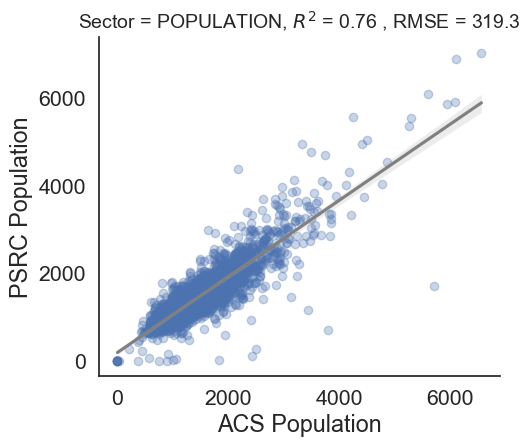

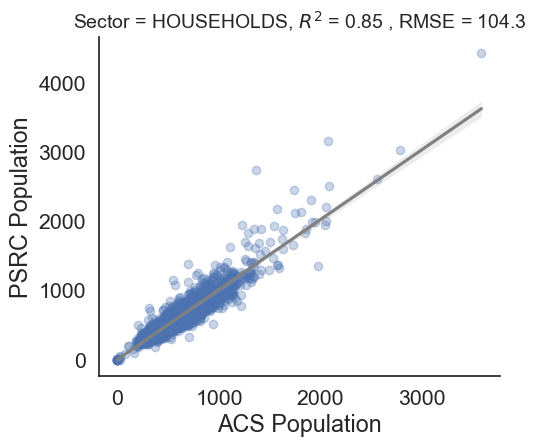

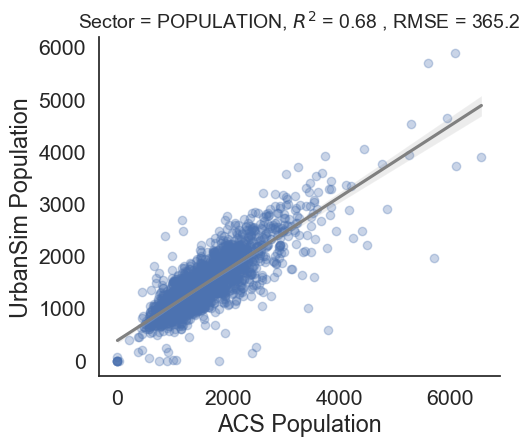

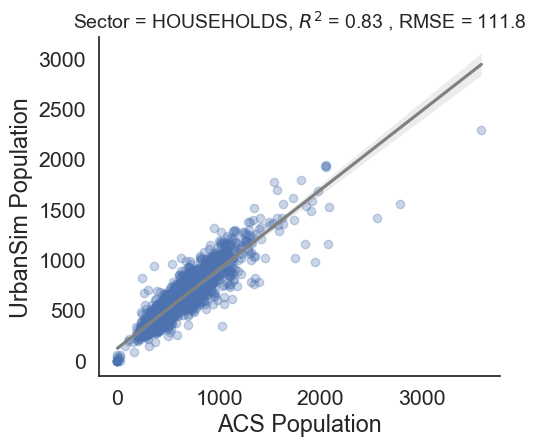

In [11]:
# compare USim, PSRC population with ACS data at cbg level
data_cbg['ACS_POPULATION'] = data_cbg['ACS_POPULATION'].astype(int)
data_cbg['ACS_HOUSEHOLDS'] = data_cbg['ACS_HOUSEHOLDS'].astype(int)
pop_comparison_with_acs = pd.merge(data_cbg, pop_comparison,
                                   on = 'GEOID', how = 'left')

pop_comparison_with_acs.fillna(0, inplace = True)

attr_col = ['ACS_POPULATION', 'ACS_HOUSEHOLDS', 
            'PSRC_POPULATION', 'PSRC_HOUSEHOLDS']
print(pop_comparison_with_acs[attr_col].sum())
# pop_comparison_with_acs.head(5)
for sec in joint_sector:
    print(sec)
    acs_attr = 'ACS_' + sec
    psrc_attr = 'PSRC_' + sec

    rmse_emp = mean_squared_error(pop_comparison_with_acs[acs_attr], 
                                  pop_comparison_with_acs[psrc_attr], squared = False)
    r2_emp = r2_score(pop_comparison_with_acs[acs_attr], 
                      pop_comparison_with_acs[psrc_attr])
    rmse_emp = np.round(rmse_emp, 1)
    r2_emp = np.round(r2_emp, 2)
    print(rmse_emp, r2_emp)
    plt.style.use('seaborn-v0_8-white')
    # plt.rcParams['axes.facecolor'] = 'white'
    sns.set(font_scale=1.4)  # crazy big
    sns.set_style("white")
    sns.lmplot(
        data=pop_comparison_with_acs,
        x=acs_attr, y=psrc_attr, 
        height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
        scatter_kws = {'alpha':0.3})
    # g.set_facecolor("white")
    
    # plt.xlim([0, 1300000])
    # plt.ylim([0, 1300000])
    plt.xlabel('ACS Population')
    plt.ylabel('PSRC Population')
    plt.title('Sector = ' + sec + ', $R^{2}$ = ' + str(r2_emp) + \
              ' , RMSE = ' + str(rmse_emp), fontsize = 14)
    plt.savefig('plot/pop_by_cbg_' + sec +'_validation_ACS.png', dpi = 200,
               bbox_inches = 'tight')

for sec in joint_sector:
    print(sec)
    acs_attr = 'ACS_' + sec
    usim_attr = 'USim_' + sec

    rmse_emp = mean_squared_error(pop_comparison_with_acs[acs_attr], 
                                  pop_comparison_with_acs[usim_attr], squared = False)
    r2_emp = r2_score(pop_comparison_with_acs[acs_attr], 
                      pop_comparison_with_acs[usim_attr])
    rmse_emp = np.round(rmse_emp, 1)
    r2_emp = np.round(r2_emp, 2)
    print(rmse_emp, r2_emp)
    plt.style.use('seaborn-v0_8-white')
    # plt.rcParams['axes.facecolor'] = 'white'
    sns.set(font_scale=1.4)  # crazy big
    sns.set_style("white")
    sns.lmplot(
        data=pop_comparison_with_acs,
        x=acs_attr, y=usim_attr, 
        height=4.5, aspect = 1.2, line_kws={'color': 'grey'}, 
        scatter_kws = {'alpha':0.3})
    # g.set_facecolor("white")
    
    # plt.xlim([0, 1300000])
    # plt.ylim([0, 1300000])
    plt.xlabel('ACS Population')
    plt.ylabel('UrbanSim Population')
    plt.title('Sector = ' + sec + ', $R^{2}$ = ' + str(r2_emp) + \
              ' , RMSE = ' + str(rmse_emp), fontsize = 14)
    plt.savefig('plot/usim_pop_by_cbg_' + sec +'_validation_ACS.png', dpi = 200,
               bbox_inches = 'tight')

In [12]:
pop_comparison_with_acs.to_csv('SoundCast_processed/synthetic_population_comparison.csv',
                              index = False)

1605263 1570662 1574725


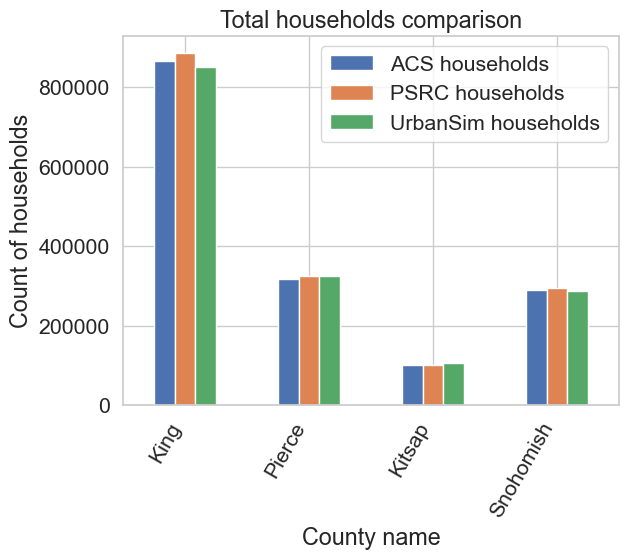

In [9]:
# compare total households
psrc_household_count = psrc_households_by_loc.groupby(['County'])[['hhno']].count()
psrc_household_count.columns = ['PSRC households']
psrc_household_count = psrc_household_count.reset_index()

usim_household_count = urbansim_household.groupby(['County'])[['household_id']].count()
usim_household_count.columns = ['UrbanSim households']
usim_household_count = usim_household_count.reset_index()

acs_household_count = acs_data[['County', 'County name', 'B11001_001E']]
acs_household_count.columns = ['County', 'County name', 'ACS households']
household_count_comparison = pd.merge(acs_household_count, psrc_household_count, 
                                      on = 'County', how = 'left')
household_count_comparison = pd.merge(household_count_comparison, usim_household_count, 
                                      on = 'County', how = 'left')
ax = household_count_comparison.plot(x = 'County name', kind = 'bar')
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
# for p in ax.containers:
#     ax.bar_label(p, label_type='edge', fontsize = 7)
plt.ylabel('Count of households')
plt.title('Total households comparison')
plt.xticks(rotation = 60)
plt.savefig('plot/household_count_by_county.png', dpi = 300, bbox_inches = 'tight')

total_psrc_hh = household_count_comparison['PSRC households'].sum()
total_usim_hh = household_count_comparison['UrbanSim households'].sum()
total_acs_hh = household_count_comparison['ACS households'].sum()
print(total_psrc_hh, total_usim_hh, total_acs_hh)
# print(total_synth_hh/total_acs_hh - 1)

4053154 3829882 4072192


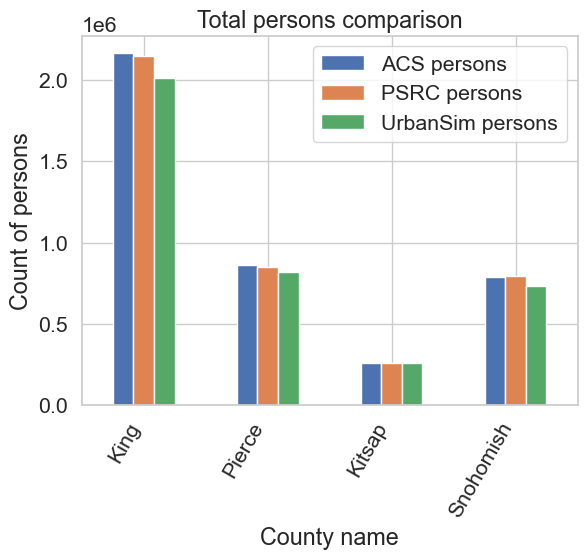

In [42]:
# compare total persons
                                              
psrc_person_count = psrc_households_by_loc.groupby(['County'])[['hhsize']].sum()
psrc_person_count.columns = ['PSRC persons']
psrc_person_count = psrc_person_count.reset_index()

usim_person_count = urbansim_household.groupby(['County'])[['persons']].sum()
usim_person_count.columns = ['UrbanSim persons']
usim_person_count = usim_person_count.reset_index()

acs_person_count = acs_data[['County', 'County name', 'B01001_001E']]
acs_person_count.columns = ['County', 'County name', 'ACS persons']
person_count_comparison = pd.merge(acs_person_count, psrc_person_count, 
                                      on = 'County', how = 'left')
person_count_comparison = pd.merge(person_count_comparison, usim_person_count, 
                                      on = 'County', how = 'left')
ax= person_count_comparison.plot(x = 'County name', kind = 'bar')
plt.ylabel('Count of persons')
plt.title('Total persons comparison')
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.savefig('plot/person_count_by_county.png', dpi = 300, bbox_inches = 'tight')

total_psrc_person = psrc_person_count['PSRC persons'].sum()
total_usim_person = usim_person_count['UrbanSim persons'].sum()
total_acs_person = person_count_comparison['ACS persons'].sum()
print(total_psrc_person, total_usim_person, total_acs_person)
# print(total_synth_person/total_acs_person - 1)

In [25]:
# compare number of workers in household
psrc_persons.loc[:, 'is_worker'] = 0
psrc_persons.loc[psrc_persons['pptyp'].isin([1, 2]), 'is_worker'] = 1
worker_count_by_hh = psrc_persons.groupby(['hhno'])[['is_worker']].sum()
worker_count_by_hh.columns = ['n_workers']
worker_count_by_hh = worker_count_by_hh.reset_index()
psrc_households_by_loc = pd.merge(psrc_households_by_loc,
                                  worker_count_by_hh,
                                  on = 'hhno', how = 'left')
psrc_households_by_loc.head(5)

,hhexpfac,hhincome,hhno,hhparcel,hhsize,hhtaz,hownrent,hrestype,ParcelID,CityName,...,TAZ,BaseYear,GEOID10,place_name,State,County,FIPS,n_child,hh_children,n_workers
0,1,83800,1,649927,1,3594,1,1,649927,Bremerton,...,3594,2018,5.303508e+14,Bremerton,53,035,53035,0,no,1
1,1,83800,2,700235,1,3591,1,1,700235,Bremerton,...,3591,2018,5.303508e+14,Bremerton,53,035,53035,0,no,1
2,1,54650,3,649754,1,3592,1,1,649754,Bremerton,...,3592,2018,5.303508e+14,Bremerton,53,035,53035,0,no,1
3,1,54650,4,649765,1,3592,1,1,649765,Bremerton,...,3592,2018,5.303508e+14,Bremerton,53,035,53035,0,no,1
4,1,54650,5,649842,1,3594,1,1,649842,Bremerton,...,3594,2018,5.303508e+14,Bremerton,53,035,53035,0,no,1


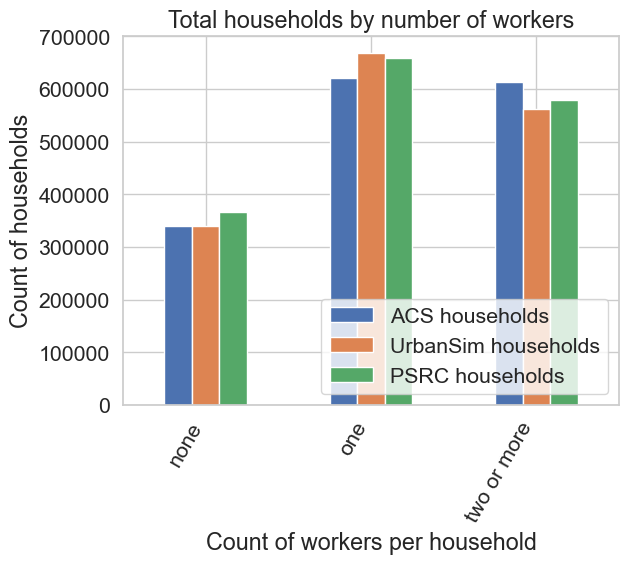

In [27]:
# compare household by number of workers
psrc_households_by_loc.loc[:, 'hh_workers'] = 'none'
psrc_households_by_loc.loc[psrc_households_by_loc['n_workers'] == 1, 
'hh_workers'] = 'one'
psrc_households_by_loc.loc[psrc_households_by_loc['n_workers'] >= 2,
'hh_workers'] = 'two or more'

psrc_household_by_workers = \
psrc_households_by_loc.groupby('hh_workers')[['hhno']].count()
psrc_household_by_workers.columns = ['PSRC households']
psrc_household_by_workers = psrc_household_by_workers.reset_index()

usim_household_by_workers = urbansim_household.groupby('hh_workers')[['household_id']].count()
usim_household_by_workers.columns = ['UrbanSim households']
usim_household_by_workers = usim_household_by_workers.reset_index()

acs_data.loc[:, 'none'] = acs_data.loc[:, 'B08202_002E']
acs_data.loc[:, 'one'] = acs_data.loc[:, 'B08202_003E']
acs_data.loc[:, 'two or more'] = acs_data.loc[:, 'B08202_004E'] + acs_data.loc[:, 'B08202_005E']

acs_household_by_workers = pd.melt(acs_data, id_vars=['County name'], 
                                   value_vars=['none', 'one', 'two or more'],
                                   var_name = 'hh_workers', value_name = 'ACS households')
acs_household_by_workers = acs_household_by_workers.groupby('hh_workers')[['ACS households']].sum()
acs_household_by_workers = acs_household_by_workers.reset_index()

household_by_worker_comparison = pd.merge(acs_household_by_workers,
                                          usim_household_by_workers,
                                          on = 'hh_workers', how = 'left')
household_by_worker_comparison = pd.merge(household_by_worker_comparison,
                                          psrc_household_by_workers,
                                          on = 'hh_workers', how = 'left')

ax = household_by_worker_comparison.plot(x = 'hh_workers', kind = 'bar')
plt.xlabel('Count of workers per household')
plt.ylabel('Count of households')
plt.title('Total households by number of workers')
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.legend(loc = 4)
plt.savefig('plot/household_count_by_workers.png', dpi = 200, bbox_inches = 'tight')

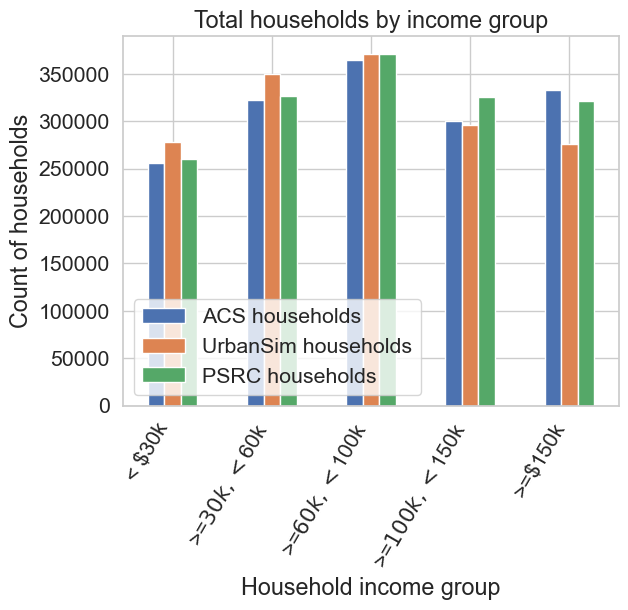

In [46]:
# household income
inc_group_lookup = {'lt30': '< $30k',
                   'gt30-lt60': '>=$30k, <$60k',
                   'gt60-lt100': '>=$60k, <$100k',
                   'gt100-lt150': '>=$100k, <$150k',
                   'gt150': '>=$150k'}

ub_lookup = {'lt30': 30000,
            'gt30-lt60': 60000,
            'gt60-lt100': 100000,
            'gt100-lt150': 150000,
            'gt150': 200000}

inc_bin = [-1, 30000, 60000, 100000, 150000, psrc_households_by_loc.hhincome.max()]
inc_bin_label = ['lt30', 'gt30-lt60', 'gt60-lt100', 'gt100-lt150',
                 'gt150']
psrc_households_by_loc.loc[:, 'hh_income'] = \
pd.cut(psrc_households_by_loc['hhincome'], bins = inc_bin, 
       right=True, labels=inc_bin_label)

psrc_household_by_income = \
psrc_households_by_loc.groupby('hh_income')[['hhno']].count()
psrc_household_by_income.columns = ['PSRC households']
psrc_household_by_income = psrc_household_by_income.reset_index()
# inflaction adj $1.14
urbansim_household.loc[:, 'adj_income'] = \
urbansim_household.loc[:, 'income'] * 1.14

urbansim_household.loc[:, 'hh_income_2'] = \
pd.cut(urbansim_household['adj_income'], bins = inc_bin, 
       right=True, labels=inc_bin_label)

usim_household_by_income = \
urbansim_household.groupby('hh_income_2')[['household_id']].count()
usim_household_by_income = usim_household_by_income.reset_index()
usim_household_by_income.columns = ['hh_income','UrbanSim households']


acs_data.loc[:, 'lt30'] = \
acs_data.loc[:, 'B19001_002E'] + acs_data.loc[:, 'B19001_003E'] + \
acs_data.loc[:, 'B19001_004E'] + acs_data.loc[:, 'B19001_005E'] + acs_data.loc[:, 'B19001_006E']

acs_data.loc[:, 'gt30-lt60'] = \
acs_data.loc[:, 'B19001_007E'] + acs_data.loc[:, 'B19001_008E'] +\
acs_data.loc[:, 'B19001_009E'] + acs_data.loc[:, 'B19001_010E'] + \
acs_data.loc[:, 'B19001_011E']

acs_data.loc[:, 'gt60-lt100'] = \
acs_data.loc[:, 'B19001_012E'] + acs_data.loc[:, 'B19001_013E']

acs_data.loc[:, 'gt100-lt150'] = \
acs_data.loc[:, 'B19001_014E'] + acs_data.loc[:, 'B19001_015E']

acs_data.loc[:, 'gt150'] = acs_data.loc[:, 'B19001_016E'] + \
acs_data.loc[:, 'B19001_017E']


acs_household_by_income = pd.melt(acs_data, id_vars=['County name'], 
                                   value_vars=['lt30', 'gt30-lt60', 'gt60-lt100', 'gt100-lt150',  'gt150'],
                                   var_name = 'hh_income', value_name = 'ACS households')
acs_household_by_income = acs_household_by_income.groupby('hh_income')[['ACS households']].sum()
acs_household_by_income = acs_household_by_income.reset_index()

household_by_income_comparison = pd.merge(acs_household_by_income,
                                          psrc_household_by_income,
                                          on = 'hh_income', how = 'left')
household_by_income_comparison = pd.merge(household_by_income_comparison,
                                          usim_household_by_income,
                                          on = 'hh_income', how = 'left')
household_by_income_comparison.loc[:, 'income_group'] = \
household_by_income_comparison.loc[:, 'hh_income'].map(inc_group_lookup)
household_by_income_comparison.loc[:, 'ub'] = \
household_by_income_comparison.loc[:, 'hh_income'].map(ub_lookup)
household_by_income_comparison = \
household_by_income_comparison.sort_values('ub', ascending = True)

ax = household_by_income_comparison[['income_group', 'ACS households', 
                                     'UrbanSim households', 'PSRC households']].plot(x = 'income_group', kind = 'bar')
plt.xlabel('Household income group')
plt.ylabel('Count of households')
plt.title('Total households by income group')
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.legend(loc = 3)
plt.savefig('plot/household_count_by_income.png', dpi = 200, bbox_inches = 'tight')

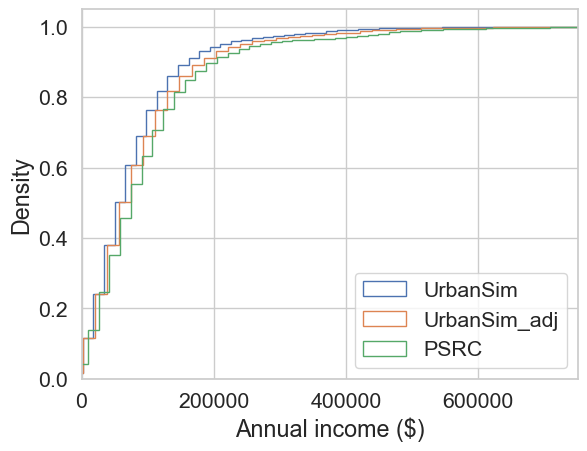

In [52]:
# income comparison 
ax1 = plt.hist(urbansim_household['income'], bins = 80, density = True,
              label = 'UrbanSim', histtype = 'step', cumulative=True)
ax1 = plt.hist(urbansim_household['adj_income'], bins = 80, density = True,
              label = 'UrbanSim_adj', histtype = 'step', cumulative=True)
ax2 = plt.hist(psrc_households_by_loc['hhincome'], bins = 80, density = True,
              label = 'PSRC', histtype = 'step', cumulative=True)
plt.xlim([0, 750000])
plt.legend()
plt.xlabel('Annual income ($)')
plt.ylabel('Density')
plt.savefig('plot/household_income_comparison.png', 
            dpi = 200, bbox_inches = 'tight')

In [29]:
print(psrc_households_by_loc.columns)
print(psrc_persons.columns)
print(psrc_persons.groupby('pgend').size())

Index(['hhexpfac', 'hhincome', 'hhno', 'hhparcel', 'hhsize', 'hhtaz',
       'hownrent', 'hrestype', 'ParcelID', 'CityName', 'Census2010Block',
       'Census2010BlockGroup', 'Census2010Tract', 'FAZID', 'taz_p', 'District',
       'district_name', 'CountyName', 'TAZ', 'BaseYear', 'GEOID10',
       'place_name', 'State', 'County', 'FIPS', 'n_child', 'hh_children',
       'n_workers', 'hh_workers'],
      dtype='object')
Index(['hhno', 'pagey', 'pdairy', 'pgend', 'pno', 'ppaidprk', 'pptyp', 'prace',
       'psexpfac', 'pspcl', 'pstaz', 'pstyp', 'ptpass', 'puwarrp', 'puwdepp',
       'puwmode', 'pwpcl', 'pwtaz', 'pwtyp', 'is_child', 'is_worker'],
      dtype='object')
pgend
-1        275
 1    2025189
 2    2027690
dtype: int64


In [21]:
# compare household with children presense
psrc_persons.loc[:, 'is_child'] = 0
psrc_persons.loc[psrc_persons['pagey'] <= 18, 'is_child'] = 1
child_count_by_hh = psrc_persons.groupby(['hhno'])[['is_child']].sum()
child_count_by_hh.columns = ['n_child']
child_count_by_hh = child_count_by_hh.reset_index()
psrc_households_by_loc = pd.merge(psrc_households_by_loc,
                                  child_count_by_hh,
                                  on = 'hhno', how = 'left')
psrc_households_by_loc.head(5)

,hhexpfac,hhincome,hhno,hhparcel,hhsize,hhtaz,hownrent,hrestype,ParcelID,CityName,...,district_name,CountyName,TAZ,BaseYear,GEOID10,place_name,State,County,FIPS,n_child
0,1,83800,1,649927,1,3594,1,1,649927,Bremerton,...,Kitsap,Kitsap,3594,2018,5.303508e+14,Bremerton,53,035,53035,0
1,1,83800,2,700235,1,3591,1,1,700235,Bremerton,...,Kitsap,Kitsap,3591,2018,5.303508e+14,Bremerton,53,035,53035,0
2,1,54650,3,649754,1,3592,1,1,649754,Bremerton,...,Kitsap,Kitsap,3592,2018,5.303508e+14,Bremerton,53,035,53035,0
3,1,54650,4,649765,1,3592,1,1,649765,Bremerton,...,Kitsap,Kitsap,3592,2018,5.303508e+14,Bremerton,53,035,53035,0
4,1,54650,5,649842,1,3594,1,1,649842,Bremerton,...,Kitsap,Kitsap,3594,2018,5.303508e+14,Bremerton,53,035,53035,0


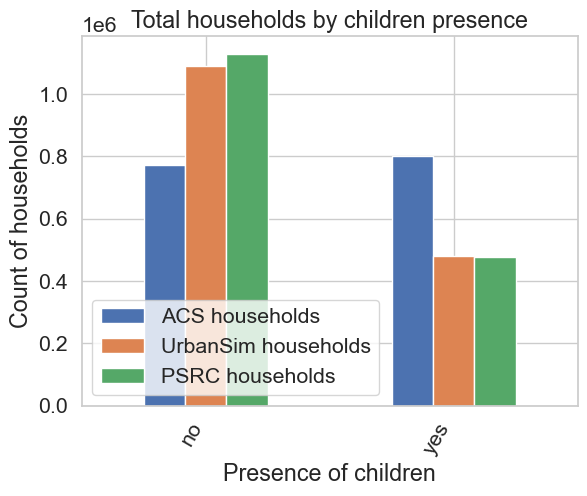

In [23]:
# compare household with children
psrc_households_by_loc.loc[:, 'hh_children'] = 'no'
psrc_households_by_loc.loc[psrc_households_by_loc['n_child']> 0, 
'hh_children'] = 'yes'

psrc_household_with_child = \
psrc_households_by_loc.groupby('hh_children')[['hhno']].count()
psrc_household_with_child.columns = ['PSRC households']
psrc_household_with_child = psrc_household_with_child.reset_index()

usim_household_with_child = \
urbansim_household.groupby('hh_children')[['household_id']].count()
usim_household_with_child.columns = ['UrbanSim households']
usim_household_with_child = usim_household_with_child.reset_index()
# modeled_household_with_child

acs_data.loc[:, 'yes'] = acs_data.loc[:, 'B09002_001E']
acs_data.loc[:, 'no'] = acs_data.loc[:, 'B11001_001E'] - \
acs_data.loc[:, 'B09002_001E']

acs_household_with_child = pd.melt(acs_data, id_vars=['County name'], 
                                   value_vars=['yes', 'no'],
                                   var_name = 'hh_children', value_name = 'ACS households')
acs_household_with_child = \
acs_household_with_child.groupby('hh_children')[['ACS households']].sum()
acs_household_with_child = acs_household_with_child.reset_index()

household_by_child_comparison = pd.merge(acs_household_with_child,
                                          usim_household_with_child,
                                          on = 'hh_children', how = 'left')
household_by_child_comparison = pd.merge(household_by_child_comparison,
                                          psrc_household_with_child,
                                          on = 'hh_children', how = 'left')
ax = household_by_child_comparison.plot(x = 'hh_children', kind = 'bar')
plt.xlabel('Presence of children')
plt.ylabel('Count of households')
plt.title('Total households by children presence')
plt.legend(loc = 3)
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.savefig('plot/household_count_by_child.png', dpi = 200, bbox_inches = 'tight')

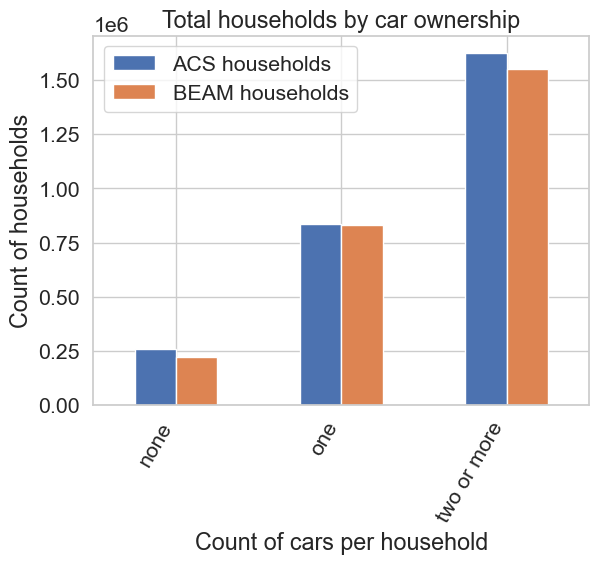

In [20]:
# compare household vehicle ownership
modeled_household_by_vehicle = households.groupby('hh_cars')[['household_id']].count()
modeled_household_by_vehicle.columns = ['BEAM households']
modeled_household_by_vehicle = modeled_household_by_vehicle.reset_index()
# modeled_household_by_vehicle

sf_data.loc[:, 'none'] = sf_data.loc[:, 'B08201_002E']
sf_data.loc[:, 'one'] = sf_data.loc[:, 'B08201_003E']
sf_data.loc[:, 'two or more'] = sf_data.loc[:, 'B08201_004E'] + \
sf_data.loc[:, 'B08201_005E'] + sf_data.loc[:, 'B08201_006E']

acs_household_by_vehicle = pd.melt(sf_data, id_vars=['County name'], 
                                   value_vars=['none', 'one', 'two or more'],
                                   var_name = 'hh_cars', value_name = 'ACS households')
acs_household_by_vehicle = acs_household_by_vehicle.groupby('hh_cars')[['ACS households']].sum()
acs_household_by_vehicle = acs_household_by_vehicle.reset_index()

household_by_vehicle_comparison = pd.merge(acs_household_by_vehicle,
                                          modeled_household_by_vehicle,
                                          on = 'hh_cars', how = 'left')

ax = household_by_vehicle_comparison.plot(x = 'hh_cars', kind = 'bar')
plt.xlabel('Count of cars per household')
plt.ylabel('Count of households')
plt.title('Total households by car ownership')
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.legend(loc = 2)
plt.savefig('plot/household_count_by_vehicle.png', dpi = 300, bbox_inches = 'tight')

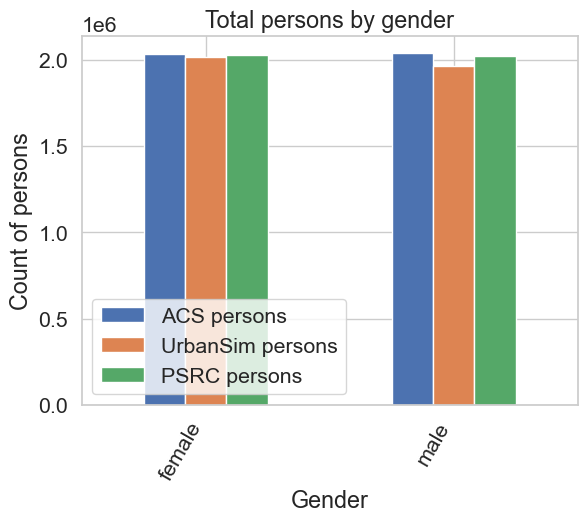

In [31]:
# compare person by gender
psrc_persons.loc[:, 'person_sex'] = 'female'
psrc_persons.loc[psrc_persons['pgend'] == 1, 'person_sex'] = 'male'
psrc_persons.loc[psrc_persons['pgend'] == -1, 'person_sex'] = 'other'

psrc_person_by_gender = psrc_persons.groupby('person_sex')[['pno']].count()
psrc_person_by_gender.columns = ['PSRC persons']
psrc_person_by_gender = psrc_person_by_gender.reset_index()
psrc_person_by_gender = \
psrc_person_by_gender.loc[psrc_person_by_gender['person_sex'] != 'other']

usim_person_by_gender = urbansim_persons.groupby('person_sex')[['person_id']].count()
usim_person_by_gender.columns = ['UrbanSim persons']
usim_person_by_gender = usim_person_by_gender.reset_index()
# person_by_gender

acs_data.loc[:, 'male'] = acs_data.loc[:, 'B01001_002E']
acs_data.loc[:, 'female'] = acs_data.loc[:, 'B01001_026E']

acs_person_by_gender = pd.melt(acs_data, id_vars=['County name'], 
                                   value_vars=['male', 'female'],
                                   var_name = 'person_sex', value_name = 'ACS persons')
acs_person_by_gender = acs_person_by_gender.groupby('person_sex')[['ACS persons']].sum()
acs_person_by_gender = acs_person_by_gender.reset_index()

person_by_gender_comparison = pd.merge(acs_person_by_gender,
                                       usim_person_by_gender,
                                       on = 'person_sex', how = 'left')
person_by_gender_comparison = pd.merge(person_by_gender_comparison,
                                       psrc_person_by_gender,
                                       on = 'person_sex', how = 'left')
ax = person_by_gender_comparison.plot(x = 'person_sex', kind = 'bar')
plt.xlabel('Gender')
plt.ylabel('Count of persons')
plt.title('Total persons by gender')
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.legend(loc = 3)
plt.savefig('plot/person_count_by_gender.png', dpi = 200, bbox_inches = 'tight')

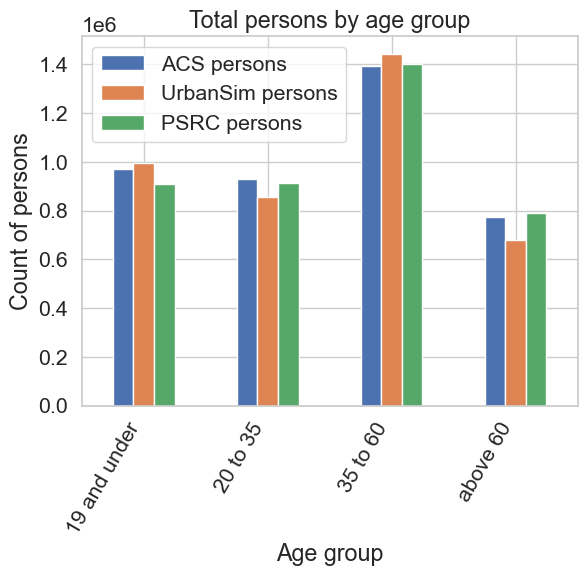

In [32]:
# compare person by age
age_bin = [0, 19, 35, 60, psrc_persons.pagey.max()]
age_bin_label = ['19 and under', '20 to 35', '35 to 60', 'above 60']

psrc_persons.loc[:, 'person_age'] = pd.cut(psrc_persons.loc[:, 'pagey'],
                                          bins = age_bin, labels = age_bin_label,
                                          right = True)
psrc_person_by_age = psrc_persons.groupby('person_age')[['pno']].count()
psrc_person_by_age.columns = ['PSRC persons']
psrc_person_by_age = psrc_person_by_age.reset_index()

usim_person_by_age = urbansim_persons.groupby('person_age')[['person_id']].count()
usim_person_by_age.columns = ['UrbanSim persons']
usim_person_by_age = usim_person_by_age.reset_index()
# person_by_age

group1_var = ['B01001_003E', 'B01001_004E', 'B01001_005E', 'B01001_006E', 'B01001_007E',
             'B01001_027E', 'B01001_028E', 'B01001_029E', 'B01001_030E', 'B01001_031E']
group2_var = ['B01001_008E', 'B01001_009E', 'B01001_010E', 'B01001_011E', 'B01001_012E', 
             'B01001_032E', 'B01001_033E', 'B01001_034E', 'B01001_035E', 'B01001_036E']
group3_var = ['B01001_013E', 'B01001_014E', 'B01001_015E', 'B01001_016E', 'B01001_017E',
             'B01001_037E', 'B01001_038E', 'B01001_039E', 'B01001_040E', 'B01001_041E']

acs_data.loc[:, '19 and under'] = acs_data.loc[:, group1_var].sum(axis = 1)
acs_data.loc[:, '20 to 35'] = acs_data.loc[:, group2_var].sum(axis = 1)
acs_data.loc[:, '35 to 60'] = acs_data.loc[:, group3_var].sum(axis = 1)
acs_data.loc[:, 'above 60'] = acs_data.loc[:, 'B01001_001E'] - \
acs_data.loc[:, '19 and under'] - acs_data.loc[:, '20 to 35'] - \
acs_data.loc[:, '35 to 60']

acs_person_by_age = pd.melt(acs_data, id_vars=['County name'], 
                                   value_vars=['19 and under', '20 to 35', '35 to 60', 'above 60'],
                                   var_name = 'person_age', value_name = 'ACS persons')
acs_person_by_age = acs_person_by_age.groupby('person_age')[['ACS persons']].sum()
acs_person_by_age = acs_person_by_age.reset_index()

person_by_age_comparison = pd.merge(acs_person_by_age,
                                       usim_person_by_age,
                                       on = 'person_age', how = 'left')
person_by_age_comparison = pd.merge(person_by_age_comparison,
                                       psrc_person_by_age,
                                       on = 'person_age', how = 'left')

ax = person_by_age_comparison.plot(x = 'person_age', kind = 'bar')
plt.xlabel('Age group')
plt.ylabel('Count of persons')
plt.title('Total persons by age group')
plt.legend(loc = 2)
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

plt.savefig('plot/person_count_by_age.png', dpi = 200, bbox_inches = 'tight')

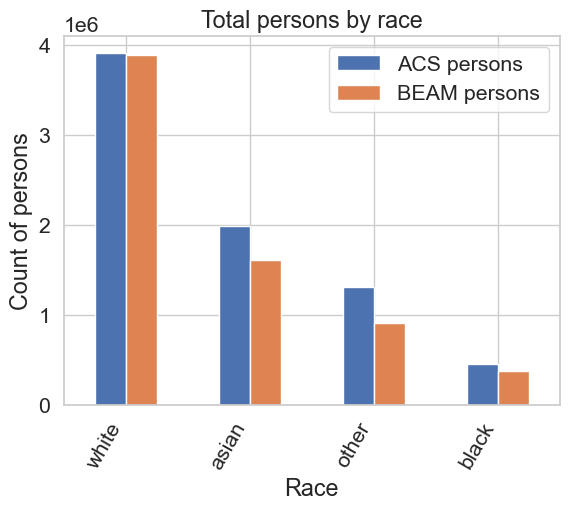

In [27]:
# compare person by age
person_by_race = persons.groupby('race')[['person_id']].count()
person_by_race.columns = ['BEAM persons']
person_by_race = person_by_race.reset_index()
# person_by_race

sf_data.loc[:, 'white'] = sf_data.loc[:, 'B02001_002E']
sf_data.loc[:, 'black'] = sf_data.loc[:, 'B02001_003E']
sf_data.loc[:, 'asian'] = sf_data.loc[:, 'B02001_005E']
sf_data.loc[:, 'other'] = sf_data.loc[:, 'B01001_001E'] - \
sf_data.loc[:, 'white'] - sf_data.loc[:, 'black'] - \
sf_data.loc[:, 'asian']

acs_person_by_race = pd.melt(sf_data, id_vars=['County name'], 
                                   value_vars=['white', 'black', 'asian', 'other'],
                                   var_name = 'race', value_name = 'ACS persons')
acs_person_by_race = acs_person_by_race.groupby('race')[['ACS persons']].sum()
acs_person_by_race = acs_person_by_race.reset_index()


person_by_race_comparison = pd.merge(acs_person_by_race,
                                       person_by_race,
                                       on = 'race', how = 'left')
person_by_race_comparison = person_by_race_comparison.sort_values('ACS persons', ascending = False)
ax = person_by_race_comparison.plot(x = 'race', kind = 'bar')
plt.xlabel('Race')
plt.ylabel('Count of persons')
plt.title('Total persons by race')
plt.legend(loc = 1)
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.savefig('plot/person_count_by_race.png', dpi = 200, bbox_inches = 'tight')

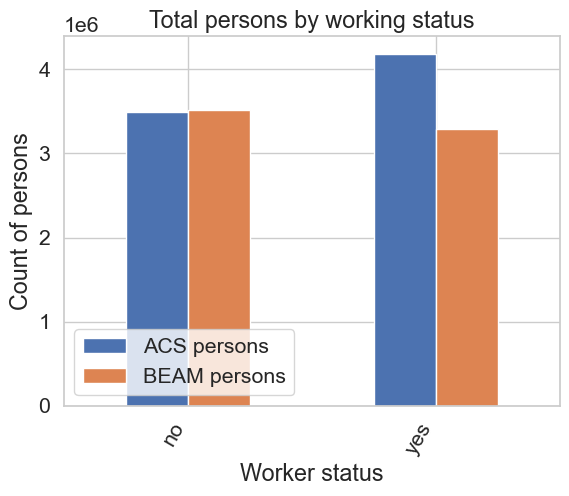

In [32]:
# compare person by worker status
person_by_worker = persons.groupby('worker')[['person_id']].count()
person_by_worker.columns = ['BEAM persons']
person_by_worker = person_by_worker.reset_index()
person_by_worker['worker'] = person_by_worker['worker'].astype(str)
# person_by_worker

sf_data.loc[:, '1'] = sf_data.loc[:, 'B23025_002E']
sf_data.loc[:, '0'] = sf_data.loc[:, 'B01001_001E'] - sf_data.loc[:, '1']


acs_person_by_worker = pd.melt(sf_data, id_vars=['County name'], 
                                   value_vars=['1', '0'],
                                   var_name = 'worker', value_name = 'ACS persons')
acs_person_by_worker = acs_person_by_worker.groupby('worker')[['ACS persons']].sum()
acs_person_by_worker = acs_person_by_worker.reset_index()

person_by_worker_comparison = pd.merge(acs_person_by_worker,
                                       person_by_worker,
                                       on = 'worker', how = 'left')
person_by_worker_comparison.loc[:, 'worker'] = \
person_by_worker_comparison.loc[:, 'worker'].map({'0':'no', '1':'yes'})
ax = person_by_worker_comparison.plot(x = 'worker', kind = 'bar')
plt.xlabel('Worker status')
plt.ylabel('Count of persons')
plt.title('Total persons by working status')
plt.legend(loc = 3)
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.savefig('plot/person_count_by_worker.png', dpi = 200, bbox_inches = 'tight')

In [20]:
# example of checking census data index
censusdata.printtable(censusdata.censustable('acs5', 2018, 'B09002'))

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B09002_001E  | OWN CHILDREN UNDER 18 YEARS BY | !! Estimate Total                                        | int  
B09002_002E  | OWN CHILDREN UNDER 18 YEARS BY | !! !! Estimate Total In married-couple families          | int  
B09002_003E  | OWN CHILDREN UNDER 18 YEARS BY | !! !! !! Estimate Total In married-couple families Under | int  
B09002_004E  | OWN CHILDREN UNDER 18 YEARS BY | !! !! !! Estimate Total In married-couple families 3 and | int  
B09002_005E  | OWN CHILDREN UNDER 18 YEARS BY | !! !! !! Estimate Total In married-couple families 5 yea | int  
B09002_006E  | OWN CHILDREN UNDER 18 YEARS BY | !! !! !! Estimate Total In married-couple families 6 to  | int  
B09002_007E  | OWN CHILDREN UNDER 18 YEARS BY | !! !! !! Estimate Total In married-couple fam